In [1]:
%%capture
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import yfinance as yf

import cvxopt as opt
from cvxopt import solvers, matrix

pd.options.display.float_format = '{:.6f}'.format

In [3]:
tickers = ['BTC-USD', 'BNB-USD', 'XRP-USD', 'TRX-USD']

# Get the current date
now = datetime.datetime.now()

# Subtract 3 months from the current date
delta = datetime.timedelta(days=91)
start_date = now - delta

# Format the date in the required format
start_date = start_date.strftime("%Y-%m-%d")
end_date = now.strftime("%Y-%m-%d")

# Minimum Variance Portfolio With Positive Weights

In [4]:
def get_close_prices(tickers, start_date, end_date):
    close_prices = pd.DataFrame()

    # Get close prices for each ticker
    for ticker in tickers:
        crypto = yf.Ticker(ticker)
        close_price = crypto.history(start=start_date, end=end_date)['Close']
        close_prices[ticker] = close_price

    # Drop rows that contain missing values
    close_prices.dropna(inplace=True)

    # Convert the index to datetime objects with the desired format
    close_prices.index = pd.to_datetime(close_prices.index, format='%Y-%m-%d')

    # Extract the year-month-day from the datetime objects and use it as the new index
    close_prices.index = close_prices.index.strftime('%Y-%m-%d')

    return close_prices


def minimum_variance_portfolio_with_positive_weights(close_prices):
    # Calculate daily returns
    returns = close_prices.pct_change().dropna()
    mean_ret = returns.mean()

    # Calculate covariance matrix
    cov_matrix = returns.cov()
    
    # Convert covariance matrix to cvxopt matrix
    Sigma = opt.matrix(cov_matrix.values)

    # Create constraint matrices
    n = len(returns.columns)
    pbar = opt.matrix(np.ones(n))
    G = opt.matrix(np.vstack((-np.eye(n), np.eye(n))))  # negative and positive n x n identity matrices; Gx <= h
    h = opt.matrix(np.vstack((np.zeros((n, 1)), np.ones((n, 1)))))  # n x 1 matrices of zeros and ones
    A = opt.matrix(1.0, (1, n))  # Ax = b
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolio_weights = solvers.qp(Sigma, pbar, G, h, A, b)  #['x']

    # Check feasibility
    if portfolio_weights['status'] == 'optimal':
        portfolio_weights = np.array(portfolio_weights['x']).flatten().tolist()
        weight_map = pd.DataFrame({'Crypto': close_prices.columns, 
                                    'Daily_Return': mean_ret.values,
                                    'Std': np.sqrt(np.diag(cov_matrix)),
                                    'Weight': [float(i) for i in portfolio_weights]})
        return weight_map


def get_portfolio_variance(w, cov_matrix):
    return np.dot(np.dot(w.T, cov_matrix), w)


def get_correlation_matrix(cov_matrix):
    # Calculate the standard deviations for each asset
    std_devs = np.sqrt(np.diag(cov_matrix))

    # Divide the covariance matrix by the product of the standard deviations
    correlation_matrix = cov_matrix / np.outer(std_devs, std_devs)

    # Replace any NaN or infinite values with 0
    correlation_matrix = np.nan_to_num(correlation_matrix, 0)

    # Convert the numpy array to a pandas dataframe and set the column and row names
    correlation_matrix = pd.DataFrame(correlation_matrix, index=cov_matrix.index, columns=cov_matrix.columns)

    return correlation_matrix

In [5]:
close_prices = get_close_prices(tickers, start_date, end_date)
weight_map = minimum_variance_portfolio_with_positive_weights(close_prices)

# Get covariance matrix
returns = close_prices.pct_change().dropna()
cov_matrix = returns.cov()

# Get weights for each asset
w = weight_map['Weight']

# Get portfolio variance
p_var = get_portfolio_variance(w, cov_matrix)

# Get correlation matrix
cor_matrix = get_correlation_matrix(cov_matrix)

print(f'Estimated standard deviation of the portfolio is {np.sqrt(p_var)}')
print('-------------------------------------------')
print('Weights DataFrame:')
print('-------------------------------------------')
print(weight_map)
print('-------------------------------------------')
print('Correlation matrix:')
print('-------------------------------------------')
print(cor_matrix)

Estimated standard deviation of the portfolio is 0.020654943469069476
-------------------------------------------
Weights DataFrame:
-------------------------------------------
    Crypto  Daily_Return      Std   Weight
0  BTC-USD      0.003775 0.022286 0.337375
1  BNB-USD      0.000584 0.026215 0.081562
2  XRP-USD     -0.000234 0.024770 0.163361
3  TRX-USD      0.002992 0.022332 0.417702
-------------------------------------------
Correlation matrix:
-------------------------------------------
         BTC-USD  BNB-USD  XRP-USD  TRX-USD
BTC-USD 1.000000 0.713474 0.743279 0.759776
BNB-USD 0.713474 1.000000 0.674864 0.651698
XRP-USD 0.743279 0.674864 1.000000 0.658573
TRX-USD 0.759776 0.651698 0.658573 1.000000


# Minimum Variance Portfolio (negative weights are allowed)

## Mathematical Concepts

$$ \sum_i x_i = 1, \quad E = E_p, \quad 
V = Var[R_p] = \sum_i \sum_j x_i x_j C_{ij}, \text{ where}$$ 


$x_i$ - weight of i-th asset in the portfolio; 

$E_p$ - fixed value of expected portfolio return; 

$V$ - variance of the portfolio.

So, we have a problem as follows. We need to find weights which minimize variance of our portfolio. We'll do this using Lagrange Multipliers method.

Lagrange function:
$$ W = V - \lambda (E - E_p) - \mu \left(\sum_i x_i - 1\right) \implies $$

\begin{align}
    \frac{\partial W}{\partial x_i} &= 2 \sum_j x_j C_{ij} - \lambda E_i - \mu = 0; \\
    \frac{\partial W}{\partial \lambda} &= - \left(\sum_i E_i x_i - E_p\right) = 0; \\
    \frac{\partial W}{\partial \mu} &= - \left(\sum_i x_i - 1\right) = 0.
\end{align}

Thus, we have the equation:
$$ Ay = b, $$

where

$$
A = 
\begin{pmatrix}
  2C & -E & -I \\
  E^T&  0 &  0 \\
  I^T&  0 &  0 \\
\end{pmatrix}
$$

\begin{align}
    y^T &= \{ X^T \; \lambda \;\; \mu \} \\
    b^T &= \{ 0 \;\; 0 \;\; \dots \;\; 0 \;\; E_p \;\; 1 \} \\
    X^T &= \{ x_1 \;\; x_2 \;\; \dots \;\; x_n \} \\
    E^T &= \{ E_1 \;\; E_2 \;\; \dots \;\; E_n \} \\
    I^T &= \{ 1 \;\; 1 \;\; \dots \;\; 1 \}
\end{align}

Now we can get the solution:

$$ y = A^{-1} b $$

$$ V = x^T C x $$

## Implementation of the algorithm

In [6]:
close_prices = get_close_prices(tickers, start_date, end_date)

# Get covariance matrix
returns = close_prices.pct_change().dropna()
E = returns.mean()
cov_matrix = returns.cov()

# Get the number of assets
N = len(E)

# Get I
I = np.ones(N)

# Get A
A = np.zeros((N + 2, N + 2))

A[:N, :N] = 2 * cov_matrix.values

A[:N, -1] = I
A[-1, :N] = I

A[:N, -2] = E
A[-2, :N] = E

A = pd.DataFrame(A)

A

,0,1,2,3,4,5
0,0.000993,0.000834,0.000821,0.000756,0.003775,1.000000
1,0.000834,0.001374,0.000876,0.000763,0.000584,1.000000
2,0.000821,0.000876,0.001227,0.000729,-0.000234,1.000000
3,0.000756,0.000763,0.000729,0.000997,0.002992,1.000000
4,0.003775,0.000584,-0.000234,0.002992,0.000000,0.000000
5,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


In [7]:
# Get the portfolio variance
invA = np.linalg.inv(A)
def get_var(Ep):
    b = np.array([0] * N + [Ep, 1])
    y = np.dot(invA, b)
    x = y[:-2]
    return np.dot(np.dot(x.T, cov_matrix), x)

# Vectorization
v_get_var = np.vectorize(get_var)

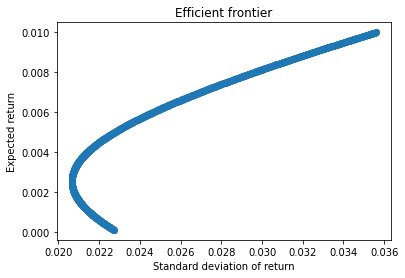

In [8]:
Ep = np.linspace(0.0001, 0.01, 1000)
Vp = np.sqrt(v_get_var(Ep))

# Visualization
plt.scatter(Vp, Ep)
plt.title("Efficient frontier")
plt.xlabel("Standard deviation of return")
plt.ylabel("Expected return")
plt.show();

In [9]:
# Get index of minimum variance element
idx_min = np.argmin(Vp)

# Get weights
b = np.array([0] * len(E) + [Ep[idx_min], 1] )
x = np.dot(invA, b)[:-2]

# Make a copy of weights_map but with new weights
weight_map_new = weight_map.copy()
weight_map_new['Weight'] = x

print(f'Estimated standard deviation of the portfolio is {Vp[idx_min]}')
print('-------------------------------------------')
print('Weights DataFrame:')
print('-------------------------------------------')
print(weight_map_new)
print('-------------------------------------------')
print('Correlation matrix:')
print('-------------------------------------------')
print(cor_matrix)

Estimated standard deviation of the portfolio is 0.02065484730535067
-------------------------------------------
Weights DataFrame:
-------------------------------------------
    Crypto  Daily_Return      Std   Weight
0  BTC-USD      0.003775 0.022286 0.338568
1  BNB-USD      0.000584 0.026215 0.078064
2  XRP-USD     -0.000234 0.024770 0.164754
3  TRX-USD      0.002992 0.022332 0.418614
-------------------------------------------
Correlation matrix:
-------------------------------------------
         BTC-USD  BNB-USD  XRP-USD  TRX-USD
BTC-USD 1.000000 0.713474 0.743279 0.759776
BNB-USD 0.713474 1.000000 0.674864 0.651698
XRP-USD 0.743279 0.674864 1.000000 0.658573
TRX-USD 0.759776 0.651698 0.658573 1.000000
